In [1]:
import pandas as pd
from PIL import Image
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import time
start_time = time.time()

In [3]:
images_path = '../images'
population_data_path = '../data/full_data.csv'

In [4]:
def crop_and_resize(image: Image.Image, size: int) -> Image.Image:
    """
    Crop a PIL image to a square by trimming the longer side and centering,
    then resize it to the designated resolution.
    
    :param image: Input PIL Image
    :param size: Target resolution (size x size)
    :return: Processed PIL Image
    """
    width, height = image.size
    min_side = min(width, height)
    
    # Calculate crop box for center cropping
    left = (width - min_side) // 2
    top = (height - min_side) // 2
    right = left + min_side
    bottom = top + min_side
    
    # Crop to square
    cropped_image = image.crop((left, top, right, bottom))
    
    # Resize to designated resolution
    resized_image = cropped_image.resize((size, size), Image.LANCZOS)
    
    return resized_image

In [5]:
images = {}

for dir in os.listdir(images_path)[:]:
    if not dir.endswith('.png'):
        continue
    
    full_path = f'{images_path}/{dir}'
    image = Image.open(full_path)
    square_image = crop_and_resize(image, 128)
    images[dir[:-4].lower()] = square_image
    
print(f'Loaded {len(images)} images')
images

Loaded 944 images


{'rio_de_janeiro': <PIL.Image.Image image mode=RGB size=128x128>,
 'sao_luis': <PIL.Image.Image image mode=RGB size=128x128>,
 'arequipa': <PIL.Image.Image image mode=RGB size=128x128>,
 'posadas': <PIL.Image.Image image mode=RGB size=128x128>,
 'zaragoza': <PIL.Image.Image image mode=RGB size=128x128>,
 "xi'an": <PIL.Image.Image image mode=RGB size=128x128>,
 'hrodna': <PIL.Image.Image image mode=RGB size=128x128>,
 'guadalajara': <PIL.Image.Image image mode=RGB size=128x128>,
 'bogor': <PIL.Image.Image image mode=RGB size=128x128>,
 'tegucigalpa': <PIL.Image.Image image mode=RGB size=128x128>,
 'siem_reap': <PIL.Image.Image image mode=RGB size=128x128>,
 'weinan': <PIL.Image.Image image mode=RGB size=128x128>,
 'al_hasakah': <PIL.Image.Image image mode=RGB size=128x128>,
 'stockholm': <PIL.Image.Image image mode=RGB size=128x128>,
 'quito': <PIL.Image.Image image mode=RGB size=128x128>,
 'surat': <PIL.Image.Image image mode=RGB size=128x128>,
 'madrid': <PIL.Image.Image image mode=RG

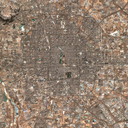

In [6]:
images['beijing']

In [7]:
images_df = pd.DataFrame.from_dict(images, orient='index', columns=['image'])
images_df = images_df.reset_index().rename(columns={'index': 'name'})
images_df

,name,image
0,rio_de_janeiro,<PIL.Image.Image image mode=RGB size=128x128 a...
1,sao_luis,<PIL.Image.Image image mode=RGB size=128x128 a...
2,arequipa,<PIL.Image.Image image mode=RGB size=128x128 a...
3,posadas,<PIL.Image.Image image mode=RGB size=128x128 a...
4,zaragoza,<PIL.Image.Image image mode=RGB size=128x128 a...
...,...,...
939,changsha,<PIL.Image.Image image mode=RGB size=128x128 a...
940,monterrey,<PIL.Image.Image image mode=RGB size=128x128 a...
941,guntur,<PIL.Image.Image image mode=RGB size=128x128 a...
942,kyiv,<PIL.Image.Image image mode=RGB size=128x128 a...


In [8]:
population = pd.read_csv(population_data_path)
population['name'] = population['name'].str.lower().str.replace(' ', '_')
population

,name,lon,lat,population
0,shanghai,121.4670,31.1667,22120000
1,beijing,116.3910,39.9050,19433000
2,shenzhen,114.0540,22.5350,15929000
3,guangzhou,113.2590,23.1288,20902000
4,chengdu,104.0670,30.6636,11309000
...,...,...,...,...
959,zadar,15.2167,44.1167,75082
960,nampula,39.2667,-15.1167,477900
961,slavonski_brod,18.0144,45.1553,56769
962,karlovac,15.5558,45.4931,53134


In [9]:
df = pd.merge(population, images_df, on='name', how='left')
df.dropna(inplace=True)
df

,name,lon,lat,population,image
0,shanghai,121.4670,31.1667,22120000,<PIL.Image.Image image mode=RGB size=128x128 a...
1,beijing,116.3910,39.9050,19433000,<PIL.Image.Image image mode=RGB size=128x128 a...
2,shenzhen,114.0540,22.5350,15929000,<PIL.Image.Image image mode=RGB size=128x128 a...
3,guangzhou,113.2590,23.1288,20902000,<PIL.Image.Image image mode=RGB size=128x128 a...
4,chengdu,104.0670,30.6636,11309000,<PIL.Image.Image image mode=RGB size=128x128 a...
...,...,...,...,...,...
959,zadar,15.2167,44.1167,75082,<PIL.Image.Image image mode=RGB size=128x128 a...
960,nampula,39.2667,-15.1167,477900,<PIL.Image.Image image mode=RGB size=128x128 a...
961,slavonski_brod,18.0144,45.1553,56769,<PIL.Image.Image image mode=RGB size=128x128 a...
962,karlovac,15.5558,45.4931,53134,<PIL.Image.Image image mode=RGB size=128x128 a...


In [10]:
def transform_population(X):
    return np.log10(np.array(X)) * 1e-1

def detransform_population(X):
    return np.pow(10, np.array(X) * 1e1)

In [11]:
transform_population(detransform_population(3))


np.float64(3.0)

In [12]:
X = df['image'].to_list()
y = (df['population']).to_list()
y_transformed = transform_population(y)
y_transformed = y_transformed.tolist()

<Axes: ylabel='Density'>

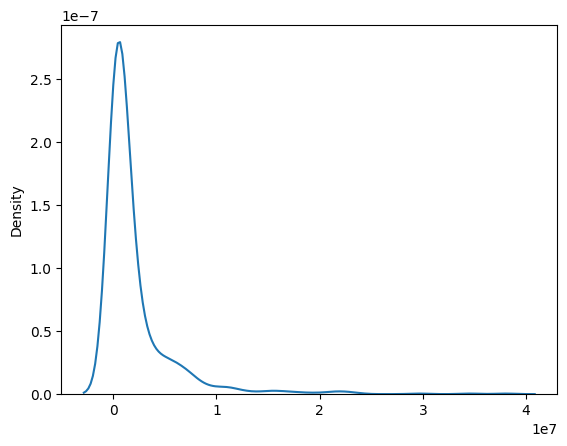

In [13]:
sns.kdeplot(y)

<Axes: ylabel='Density'>

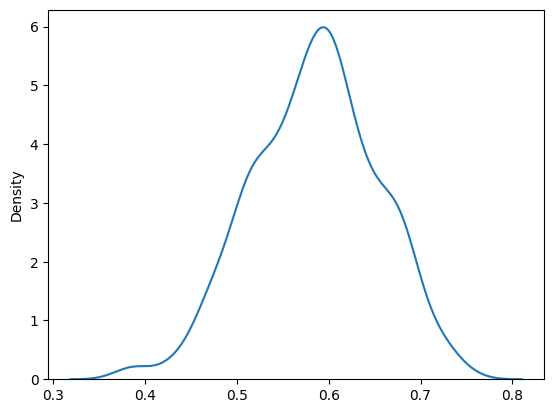

In [14]:
sns.kdeplot(y_transformed)

In [15]:
class PILImageListValueDataset(Dataset):
    """
    Dataset class to load a list of PIL images and a corresponding list of values.
    """
    def __init__(self, image_list, target_values, transform=None):
        """
        Args:
            image_list (list): A list of PIL Image objects.
            target_values (list): A list of target values corresponding to each image.
                                  Ensure the length matches the image_list.
            transform (callable, optional): Optional transform to be applied
                on the image. Defaults to None.
        """
        if len(image_list) != len(target_values):
            raise ValueError("The length of image_list and target_values must be the same.")

        self.image_list = image_list
        self.target_values = target_values
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image = self.image_list[idx]
        target_value = self.target_values[idx]

        if torch.rand(1) < 0.5:
            image = image.rotate(90)

        if torch.rand(1) < 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)

        if torch.rand(1) < 0.5:
            image = image.transpose(Image.FLIP_TOP_BOTTOM)

        if self.transform:
            image = self.transform(image)

        # Convert target_value to a PyTorch Tensor if it's not already
        if not isinstance(target_value, torch.Tensor):
            target_value = torch.tensor(target_value).float()  # Adjust dtype as needed

        return image, target_value 

In [48]:
X
(df['lat']) / 90
(df['lon']) / 180

0      0.674817
1      0.646617
2      0.633633
3      0.629217
4      0.578150
         ...   
959    0.084537
960    0.218148
961    0.100080
962    0.086421
963    0.248847
Name: lon, Length: 964, dtype: float64

In [16]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = PILImageListValueDataset(X, torch.Tensor(y_transformed).reshape(-1, 1), data_transform)
ratio = 0.8
train_len = int(len(dataset) * ratio)
test_len = len(dataset) - train_len
train_dataset, test_dataset = random_split(dataset, [train_len, test_len])

train_loader = DataLoader(
    train_dataset,
    64,
    True
)

len(train_dataset)

771

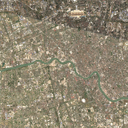

In [17]:
transforms.ToPILImage()(dataset[0][0])

In [18]:
class RelativeLoss(nn.Module):
    """
    Computes the Relative Loss (also known as Normalized Loss or Percentage Loss).

    The relative loss is defined as:
    (|target - prediction|) / (|target| + epsilon)

    where epsilon is a small constant to avoid division by zero when the target is zero.
    """
    def __init__(self, epsilon=1e-8):
        super(RelativeLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, prediction, target):
        """
        Args:
            prediction (torch.Tensor): The predicted values.
            target (torch.Tensor): The ground truth values.

        Returns:
            torch.Tensor: The computed relative loss.
        """
        numerator = torch.abs(target - prediction)
        denominator = torch.abs(target) + self.epsilon
        relative_loss = numerator / denominator
        return relative_loss.mean()

In [19]:
model = nn.Sequential(
    nn.Conv2d(3, 32, 3, 1, 'same'),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Dropout(0.1),
    nn.Conv2d(32, 64, 3, 1, 'same'),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Dropout(0.1),
    nn.Conv2d(64, 128, 3, 1, 'same'),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Dropout(0.1),
    nn.Conv2d(128, 128, 3, 1, 'same'),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Dropout(0.1),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Linear(32, 8),
    nn.ReLU(),
    nn.Linear(8, 1)
)


y_loss = []
optim = torch.optim.Adam(model.parameters(), 1e-3)
criterion = nn.MSELoss()

In [34]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(dev)
model.train()

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Dropout(p=0.1, inplace=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Dropout(p=0.1, inplace=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Dropout(p=0.1, inplace=False)
  (15): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (16): BatchNorm2d(128, eps=1e-05,

In [35]:
epoch_n = 1024

for epoch in range(epoch_n):
    # Set the model to training mode
    model.train()
    epoch_loss = 0.0
    num_batches = 0

    # Iterate over the batches in the DataLoader
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move the input and target tensors to the device (e.g., GPU if available)
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()
        
        # Forward pass
        predictions = model(inputs)

        # Calculate the loss
        loss = criterion(predictions, targets)

        # Backward pass and optimization
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Record the loss for this batch
        epoch_loss += loss.item()
        num_batches += 1

        # Optional: Print batch-level loss
        # if batch_idx % 100 == 0:
        #     print(f"Epoch [{epoch+1}/{epoch_n}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Calculate the average loss for the epoch
    avg_epoch_loss = epoch_loss / num_batches
    y_loss.append(avg_epoch_loss)

    # Print the average loss for the epoch
    print(f"Epoch [{epoch+1}/{epoch_n}], Average Loss: {avg_epoch_loss:.4f}")

Epoch [1/1024], Average Loss: 0.0008
Epoch [2/1024], Average Loss: 0.0006
Epoch [3/1024], Average Loss: 0.0008
Epoch [4/1024], Average Loss: 0.0008
Epoch [5/1024], Average Loss: 0.0009
Epoch [6/1024], Average Loss: 0.0008
Epoch [7/1024], Average Loss: 0.0007
Epoch [8/1024], Average Loss: 0.0017
Epoch [9/1024], Average Loss: 0.0015
Epoch [10/1024], Average Loss: 0.0018
Epoch [11/1024], Average Loss: 0.0016
Epoch [12/1024], Average Loss: 0.0016
Epoch [13/1024], Average Loss: 0.0013
Epoch [14/1024], Average Loss: 0.0011
Epoch [15/1024], Average Loss: 0.0010
Epoch [16/1024], Average Loss: 0.0014
Epoch [17/1024], Average Loss: 0.0010
Epoch [18/1024], Average Loss: 0.0009
Epoch [19/1024], Average Loss: 0.0010
Epoch [20/1024], Average Loss: 0.0011
Epoch [21/1024], Average Loss: 0.0009
Epoch [22/1024], Average Loss: 0.0008
Epoch [23/1024], Average Loss: 0.0008
Epoch [24/1024], Average Loss: 0.0009
Epoch [25/1024], Average Loss: 0.0007
Epoch [26/1024], Average Loss: 0.0006
Epoch [27/1024], Aver

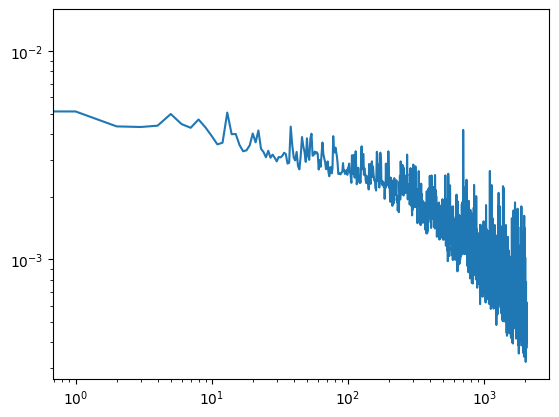

In [36]:
plt.plot(y_loss)
plt.yscale('log')
plt.xscale('log')

In [37]:
model.eval()

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Dropout(p=0.1, inplace=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Dropout(p=0.1, inplace=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Dropout(p=0.1, inplace=False)
  (15): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (16): BatchNorm2d(128, eps=1e-05,

In [38]:
model.to('cpu')
a = 0

for (img, population) in test_dataset:
    prediction = model(img.unsqueeze(0))
    prediction = detransform_population(prediction.detach().numpy())
    true_population = detransform_population(population.detach().numpy())
    a += (np.abs(prediction - true_population)) / true_population
    
a /= len(test_dataset)
print(a)


[[2.8913274]]


[[2.8826275]]


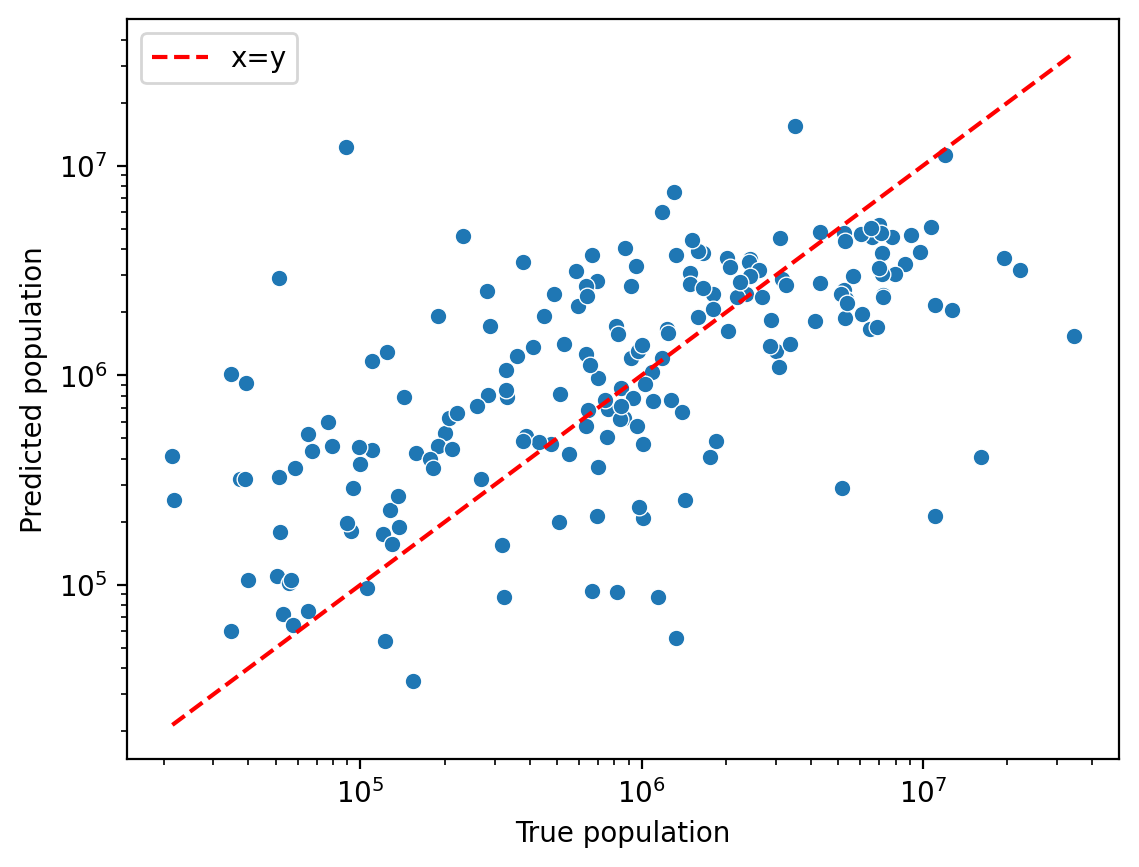

In [39]:
a = 0

true_population_full = []
predicted_population_full = []

for (img, population) in test_dataset:
    prediction = model(img.unsqueeze(0))
    prediction = detransform_population(prediction.detach().numpy())
    true_population = detransform_population(population.detach().numpy())
    predicted_population_full.append(prediction[0].item())
    true_population_full.append(true_population[0].item())
    a += (np.abs(prediction - true_population)) / true_population
    
a /= len(test_dataset)
print(a)

plt.figure(dpi=200)
sns.scatterplot(x=true_population_full, y=predicted_population_full)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('True population')
plt.ylabel('Predicted population')

plt.plot([min(true_population_full), max(true_population_full)], 
         [min(true_population_full), max(true_population_full)], 
         'r--', label='x=y')
plt.legend()


In [26]:
img = train_dataset[5][0]
population = train_dataset[5][1]
prediction = model(img.unsqueeze(0))
prediction = detransform_population(prediction.detach().numpy())
population = detransform_population(population.detach().numpy())
relative_error = (np.abs(prediction - population)) / population
print(f'Population: {np.round(population.item())}\nprediction: {np.round(prediction.item())}\nrelacive error: {np.round(relative_error.item() * 100, 2)}%')

Population: 41528.0
prediction: 139560.0
relacive error: 236.06%


In [27]:
end_time = time.time()
execution_time = end_time - start_time
print(f"Total execution time: {execution_time:.2f} seconds")

Total execution time: 834.79 seconds
